In [97]:
import os
import datetime
import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from dotenv import load_dotenv
import urllib.parse
import matplotlib.pyplot as plt

load_dotenv()
POSTGRES_USERNAME = os.environ.get('JDB_USER')
POSTGRES_PASSWORD = os.environ.get('JDB_PASSWORD')
POSTGRES_ADDRESS = os.environ.get('JDB_HOST')
POSTGRES_PORT = 5432
POSTGRES_DBNAME = os.environ.get('JDB_NAME')
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'.format(username=POSTGRES_USERNAME, password=POSTGRES_PASSWORD, ipaddress=POSTGRES_ADDRESS, port=POSTGRES_PORT, dbname=POSTGRES_DBNAME))
cnx = create_engine(postgres_str)

In [101]:
stays = pd.read_sql_query('select * from stays_summarized where end_date is not null and is_pretrial = 1 and not_primary_custodian = 0;', cnx)
stays

,defendant_id,name,gender,race,start_date,end_date,days,rank,is_pretrial,is_violent,is_dwi,not_primary_custodian,is_violation,flag,use_flag
0,35387,"CAMERON, STEFAN MIKEL",M,W,2022-03-05,2022-04-14,41.0,11,1,0,0,0,0,0,1
1,35409,"COOLEY, SUNNY MARIE",F,W,2022-03-05,2022-05-18,75.0,11,1,0,0,0,0,0,1
2,35442,"EDWARDS, MICHAEL EUGENE",M,W,2022-03-05,2022-03-08,4.0,3,1,0,0,0,0,0,1
3,8176,"RAINES, JESSE LEE",M,B,2022-01-03,2022-07-01,180.0,14,1,1,0,0,1,1,0
4,35505,"HOOPENGARNER, MATTHEW GARLAND",M,W,2022-03-05,2022-03-18,14.0,11,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,70774,"HELMS, ERIK ALLEN",M,W,2022-05-24,2022-07-01,39.0,4,1,1,0,0,1,0,1
2066,69382,"JOHNSON, ADAM GRANT",M,W,2022-05-21,2022-07-01,42.0,5,1,0,0,0,0,0,1
2067,8101,"MAEWETHER, TRISTIN MARQUESE",M,B,2022-01-03,2022-07-01,180.0,7,1,0,0,0,1,1,0
2068,71399,"PLEMMONS, SETH WILLIAM",M,W,2022-05-25,2022-07-01,38.0,7,1,0,0,0,1,0,1


In [102]:
bstays = stays.loc[stays["race"] == "B"].copy()

daysB = pd.Series([len(bstays[bstays['days'] <= 7]), 
       len(bstays[(bstays['days'] <= 30) & (bstays['days'] > 7)]),
       len(bstays[(bstays['days'] <= 90) & (bstays['days'] > 30)]),
       len(bstays[bstays['days'] > 90])])

wstays = stays.loc[stays["race"] == "W"].copy()

daysW = pd.Series([len(wstays[wstays['days'] <= 7]), 
       len(wstays[(wstays['days'] <= 30) & (wstays['days'] > 7)]),
       len(wstays[(wstays['days'] <= 90) & (wstays['days'] > 30)]),
       len(wstays[wstays['days'] > 90])])


daysRace = pd.concat([daysW, daysB], axis=1)
daysRace.columns = ['White', 'Black']
daysRace.index.name = 'Days'
daysRace.index = ['Week or less', '8-30 days', '31-90 days', 'Over 90 days']
daysRace['Black'] = round(100 * daysRace['Black']/daysRace['Black'].sum(),2)
daysRace['White'] = round(100 * daysRace['White']/daysRace['White'].sum(),2)
#daysRace['Diff']  = daysRace['White'] - daysRace['Black']
daysRace


,White,Black
Week or less,64.67,59.14
8-30 days,20.29,19.35
31-90 days,12.32,17.74
Over 90 days,2.72,3.76


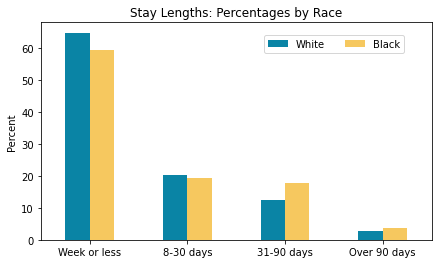

In [116]:
def addlabels(x,y, offset, color):
    for i in range(len(x)):
        val = round(y[i],2)
        plt.text(i-offset, -10, val, ha = 'center', rotation='vertical', color = color, fontweight='bold')
colors = ['#0a84a5', '#f6c85f', '#6f4d7c', '#9cd766', '#ca472f', '#ff9f56', '#8cddd0', ]
daysRace.plot.bar(title="Stay Lengths: Percentages by Race", figsize=[7,4], color=[colors[0],colors[1]])
plt.ylabel('Percent')
plt.legend()
plt.legend(bbox_to_anchor=[.75, 0.9], loc='center', ncol=2)
plt.xticks(rotation=0)
plt.savefig('/Users/ejaxon/development/jail/stay-lengths-by-race.png', bbox_inches='tight')


In [120]:
fstays = stays.loc[stays["gender"] == "F"].copy()

daysF = pd.Series([len(fstays[fstays['days'] <= 7]), 
       len(fstays[(fstays['days'] <= 30) & (fstays['days'] > 7)]),
       len(fstays[(fstays['days'] <= 90) & (fstays['days'] > 30)]),
       len(fstays[fstays['days'] > 90])])

mstays = stays.loc[stays["gender"] == "M"].copy()

daysM = pd.Series([len(mstays[mstays['days'] <= 7]), 
       len(mstays[(mstays['days'] <= 30) & (mstays['days'] > 7)]),
       len(mstays[(mstays['days'] <= 90) & (mstays['days'] > 30)]),
       len(mstays[mstays['days'] > 90])])


daysGender = pd.concat([daysM, daysF], axis=1)
daysGender.columns = ['Male', 'Female']
daysGender.index.name = 'Days'
daysGender.index = ['Week or less', '8-30 days', '31-90 days', 'Over 90 days']
daysGender['Female'] = round(100 * daysGender['Female']/daysGender['Female'].sum(),2)
daysGender['Male'] = round(100 * daysGender['Male']/daysGender['Male'].sum(),2)
daysGender

,Male,Female
Week or less,61.24,71.03
8-30 days,20.18,20.63
31-90 days,14.81,8.33
Over 90 days,3.77,0.00


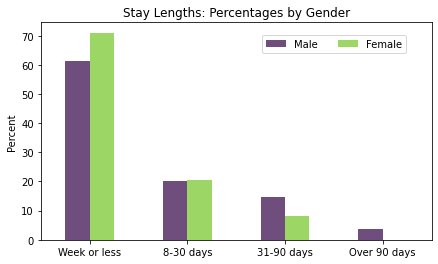

In [121]:
def addlabels(x,y, offset, color):
    for i in range(len(x)):
        val = round(y[i],2)
        plt.text(i-offset, -10, val, ha = 'center', rotation='vertical', color = color, fontweight='bold')

daysGender.plot.bar(title="Stay Lengths: Percentages by Gender", figsize=[7,4], color=[colors[2],colors[3]])
plt.ylabel('Percent')
plt.legend()
plt.legend(bbox_to_anchor=[.75, 0.9], loc='center', ncol=2)
plt.xticks(rotation=0)
plt.savefig('/Users/ejaxon/development/jail/stay-lengths-by-gender.png', bbox_inches='tight')


In [122]:
daysAll = pd.concat([daysRace, daysGender], axis=1)
daysAll

,White,Black,Male,Female
Week or less,64.67,59.14,61.24,71.03
8-30 days,20.29,19.35,20.18,20.63
31-90 days,12.32,17.74,14.81,8.33
Over 90 days,2.72,3.76,3.77,0.00
